<a href="https://colab.research.google.com/github/teearkay/text_summarization_using_seq2seq/blob/master/Text_Summarization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Abstractive Summarization of Legal Judgements**

Using Seq2Seq Encoder-Decoder Model with Bahdanau's Attention Model

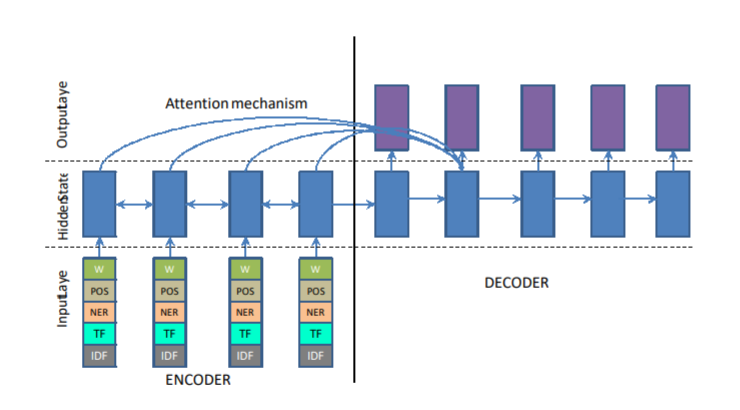

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## **Pre-processing Judgement Data-Metadata**

##### Cleaning Data 
##### Extracting Linguistic Features such as:
##### - POS (Part of Speech) Tagging
##### - Named Entity Recognition
##### - TF-IDF for words in each document

Imports

In [ ]:
import json
from bs4 import BeautifulSoup

import re

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelBinarizer

In [ ]:
# ! python -m spacy download en_core_web_lg

✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_lg')


In [ ]:
import spacy 
import en_core_web_lg
from spacy import displacy
from spacy.tokens import Span, Doc
nlp = spacy.load('en_core_web_lg')

from spacy.lang.en import English
tokenizer = English()

<h3>Importing Judgements and Preprocessing Metadata</h3>

In [ ]:
with open('/content/drive/My Drive/NLP (ML)/response.json',encoding="utf8") as f:
    mydata = json.load(f)

Content dictionary

In [ ]:
document = {}

In [ ]:
for obj in mydata['hits']:
    _id = obj['_id']
    doc = _id
    content = obj['_source']['content']
    html_soup = BeautifulSoup(content,'html.parser')
    flag=1
    for para in html_soup.find_all('p'):
        if(para.text!="@JUDGMENTTAG-JUDGMENT"):
            if(flag):
                flag=0
                continue
            doc+= "<para>\n" + para.get_text(strip=True)
    document[_id] = doc

In [ ]:
# DO NOT RUN

#some cases were not yeilding the correct corpus. Correction is to take all paras, not just from the body.

html = BeautifulSoup(mydata['hits'][14]['_source']['content'],'html.parser')
doc = ""
for para in html.find_all('p'):
    if(para.text!="@JUDGMENTTAG-JUDGMENT"):
            if(flag):
                flag=0
                continue
            doc+= "<para>\n" + para.get_text(strip=True)
text = doc
text=re.sub("\xa0",' ',text)
text=re.sub("\xad",' ',text)
text=re.sub('\r\n',' ',text)
text = re.sub("<para>\n\d*\.*",'\n',text)
print(text)


L. Nageswara Rao, J
Leave granted.
 The validity of appointment to the posts of Junior Linemen in the Andhra Pradesh Transmission Corporation (A.P. TRANSCO) and the four Andhra Pradesh Distribution Companies (DISCOMS) in the erstwhile combined State of Andhra Pradesh is in issue in these appeals.
 On 07.06.2006, the Special Chief Secretary, Energy Department, Government of Andhra Pradesh permitted the Chairman & Managing Director, A.P. TRANSCO and the Chairpersons, Andhra Pradesh Power Coordination Committee (APPCC) to fill up 7114 posts of Junior Linemen on contract basis in the four DISCOMS duly following the rule of reservation. The appointment on contract basis was to be for a period of one year which would cease automatically after the said period. Pursuant to the said permission granted by the Government, the A.P. TRANSCO and the four DISCOMS advertised 7114 vacancies and called for applications from the eligible candidates for the post of Junior Lineman vide separate notificati

List of IDs for Lookup

In [ ]:
ids = []
rev_ids = {}
for obj in mydata['hits']:
    ids.append(obj['_id'])
for i in range(len(ids)):
    rev_ids[ids[i]] = i
print(ids)
print(rev_ids)

['2363218', '2364094', '2363468', '2363460', '2363463', '2363451', '2363455', '2363448', '2363434', '2363439', '2363430', '2363431', '2363823', '2363426', '2363425', '2363414', '2363407', '2363406', '2363410', '2363395', '2363393', '2363390', '2363376', '2363382', '2363377', '2363486', '2363470', '2363819', '2363404', '2363399', '2363579', '2363860', '2363574', '2363573', '2363566', '2364836', '2363556', '2363850', '2363546', '2363532', '2363847', '2363662', '2363540', '2363846', '2363519', '2363521', '2363512', '2363520', '2363516', '2363840', '2363499', '2363489', '2363834', '2364072', '2363675', '2363679', '2363741', '2363744', '2363747', '2363659', '2363757', '2363625', '2363611', '2363613', '2364124']
{'2363218': 0, '2364094': 1, '2363468': 2, '2363460': 3, '2363463': 4, '2363451': 5, '2363455': 6, '2363448': 7, '2363434': 8, '2363439': 9, '2363430': 10, '2363431': 11, '2363823': 12, '2363426': 13, '2363425': 14, '2363414': 15, '2363407': 16, '2363406': 17, '2363410': 18, '2363395

Extracting Corpus

In [ ]:
corpus = {}

In [ ]:
for i in document:
    text = document[i]
    text=re.sub("\xa0",' ',text)
    text=re.sub("\xad",' ',text)
    text=re.sub('\r\n',' ',text)
    text = re.sub("<para>\n\d*\.*",'\n',text)
    text = re.sub("\n",' ',text)
    corpus[i] = text

In [ ]:
corpus[ids[0]]

'2363218  Leave granted.  The question involved is as to the permissible alteration in a Motor Vehicle in view of the provisions contained in section 52 of the Motor Vehicles Act, 1988 (hereinafter referred to as “the Act”), Rule 126 of the Central Motor Vehicles Rules, 1989 and the effect of Rules 96, 103 and 261 of the Kerala Motor Vehicle Rules, 1989. The Central Government has framed the rules called Central Motor Vehicle Rules, 1989 (for short “the Central Rules”) in exercise of the power conferred under section 27 of the Act, and in exercise of powers conferred under Section 28 of the Act, the Kerala Government has framed the Kerala Motor Vehicle Rules, 1989 (hereinafter referred to as “the Kerala Rules”). The validity of Circular No.7/2006 issued by the Transport Commissioner, Kerala to all the Registering Authorities stating that the body of the vehicle constructed in violation of the prototype test certificate and which was not built in strict compliance of the specifications 

Extracting Metadata

In [ ]:
# fields present
for i in range(len(mydata['hits'])):
    fields = list(mydata['hits'][0]['_source'].keys())
    print(fields)
#     vals = list(mydata['hits'][0]['_source'].items())
#     print(vals)
    break

['date', 'case_no', 'bench', 'docid', 'respondent', 'appellant', 'ckcitation', 'acts', 'court', 'coram_nested', 'content', 'result', 'counsel_nested', 'post_date', 'citation_nested', 'abbr', 'coram_count']


In [ ]:
metadata = {}

In [ ]:
for obj in mydata['hits']:
    _id = obj['_id']
    src = obj['_source']
    court = src['court']
    case_no = src['case_no']
    coram = []
    counsel = []
    for crm in src['coram_nested']:
        coram.append(crm['value'])
    for cns in src['counsel_nested']:
        counsel.append(cns['value'])
    ck_citation = src['ckcitation']
    date = src['date']
    acts = src['acts']
    abbr = src['abbr']
    try:
        result = src['result']
    except: 
        result = ""
#     casename = src['casename']
    appellant = src['appellant'].split('@')
    respondent = src['respondent'].split('@')
    curdata = {
        "court": court,
        "case_no": case_no,
        "coram": coram,
        "counsel": counsel,
        "ck_citation": ck_citation,
        "date": date,
        "acts": acts,
        "abbr": abbr,
        "result": result,
#         "casename": casename,
        "appellant": appellant,
        "respondent": respondent
    }
    metadata[_id] = curdata
#     break
#     print(court,'/',case_no,'/',)

In [ ]:
for i in ids:
    print(metadata[i])

{'court': 'Supreme Court Of India', 'case_no': 'Civil Appeal No. 219, 222, 223 Of 2019', 'coram': ['Arun Mishra, J', 'Vineet Saran, J'], 'counsel': ['nishe rajen shonker', 'jogy scaria'], 'ck_citation': '(2019) 01 SC CK 0031', 'date': '09-01-2019', 'acts': [{'rules': 'Rule 47, 47(1)(a), 47(1)(d), 47(1)(g), 47(a), 47(d), 48, 92, 92(1), 100, 104A, 106, 126', 'title': 'Central Motor Vehicles Rules, 1989'}, {'rules': 'Rule 93, 93(1), 93(2), 93(4), 93(6), 96, 103, 261', 'title': 'Kerala Motor Vehicle Rules, 1989'}, {'section': 'Section 27, 28, 52', 'title': 'Motor Vehicles Act, 1988'}, {'section': 'Section 32', 'title': 'Motor Vehicles Act, 1939'}, {'section': 'Section 52, 52(1), 52(1)(a), 52(1)(b), 52(2), 52(3), 52(4), 52(5), 52(6)', 'title': 'Motor Vehicles (Amendment) Act, 2000'}], 'abbr': 'SC', 'result': 'Allowed', 'appellant': ['Regional Transport Officer & Ors. Etc'], 'respondent': ['K. Jayachandra & Anr. Etc']}
{'court': 'Supreme Court Of India', 'case_no': 'Criminal Appeal Nos. 45, 

Judge Titles

In [ ]:
txxt = """All the accused have been awarded the death penalty for the offence punishable under Section 302 read with Section 34 of IPC.
Raghunath who was having his house in Survey No. 19 immediately rushed to the spot in his jeep and noticed that Trambaks elder son Manoj (PW 1) and wife Vimalabai (PW 8) were murmuring but unconscious and he immediately shifted both of them to the Municipal Hospital called Bytco hospital at Nashik.
Vishnu (PW 12) had also intimated to the police simultaneously and they arrived at the spot and noticed that Trambak, his two sons viz. Sandeep and Bhurya @ Shrikant, daughter Savita and his sister-in-laws son Bharat More were found dead.
3. As per the prosecution case on 5/6/2003 Trambak and all his family members as well as the guest Bharat More were chitchatting after dinner and at about 10.30 p.m. seven to eight unknown persons entered his hut and all of them were on banyan and half pant and they started threatening the family members.
The police during the course of investigation also got information that some other accused were also involved in a separate crime registered with the police station at Bhokardhan in Jalna district on 19/6/2003 and the police filed an application before the competent Court seeking transfer of the accused in Crime No. 74 of 2003 registered with the Bhokardhan police station and finally accused Nos. 3 to 5 came to be arrested on 27/6/2003 under arrest panchanamas (Exhibits 53, 54 and 55) after their custody was transferred from the police station at Bhokardhan.
Both PW 1 and PW 8 had identified the said accused who was one of the unknown persons who entered their hut and assaulted the family members.
6. Criminal Application No. 1 of 2006 was filed by the State of Maharashtra and Criminal Application No. 2 of 2006 was filed by the accused persons before this Court.
PW 8 and PW 13 were further cross-examined by the defence and the prosecution examined one additional witness i.e. Shri Govind Alhate, City Magistrate at Nashik as PW 25.
It has come in the evidence of PW 1 -Manoj and PW 8 -Vimalabai that the family members had taken meals around 9 p.m. on 5/6/2003 and Trambak, Sandeep, Savita, Shrikant and Bharat could be said to have died between 1 a.m. to 3 a.m. on 6/6/2003 on account of the assault they had received from the dacoits.
It is further alleged that when the witnesses i.e. PW 1 and PW 8 were called one after another, they were told by the police personnel present about the identity of the accused and the parade was vitiated.
The identity of the accused based on this TI parade which was utterly faulty, has to be discarded and in any case the said TI parade was not proved by examining PW 25 Mr.
As per the defence the testimony of PW 1 is inconsistent, contradictory and untrustworthy and unreliable.
The said witness had stated before the police that when the accused had entered the hut they started assaulting the inmates and increased the volume of the tape-recorder and switched off the lights.
In short it is contended that the evidence of PW 1 Manoj did not inspire confidence and ought to be discarded per_se.
The inconsistencies and contradictions in the said statement are writ large and Vimalabai PW 8 is a totally unreliable witness of the prosecution, urged the learned Senior Counsel for the accused.
It is also submitted that no weapons were recovered at the instance of the accused and whatever weapons were produced before the trial Court they were seized from the spot of the incident i.e. the hut of Trambak and brought before the trial Court.
The accused were for the first time identified before the trial Court and the purported test identification parade held on 25/7/2003 was not proved before the trial Court and an adverse inference is required to be drawn so far as accused Nos. 1 to 5 are concerned.
It was claimed by the learned APP that PW 1 Manoj also had sufficient time to identify the accused and he identified all the five accused in the TI parade held on 25/7/2003.
Merely saying that in the report submitted by PW 25 the height and age of every person used as dummy was not mentioned and the Magistrate failed to conduct the parade as required, cannot vitiate the TI parade.
Even otherwise we have noted that PW 8 could not identify accused No. 2 Rajya Appa Shinde as is clear from the depositions of PW 25 and she identified the remaining four accused persons whereas PW 1 Manoj identified all the five accused.
We have seen the requisition dated 7/6/2003 received by PW 13 and from its original available in the Court which was not exhibited by the trial Court inspite of specific application having been filed by the defence, it is clear that the said requisition was not for recording the dying declaration of PW 8.
We have to at the first instance, test the veracity or reliability of the evidence of PW 1 and PW 8.
The trial Court in the instant case has tested the evidence of both these witnesses and rightly held that they were natural and reliable witnesses.
The statement of PW 8 recorded by PW 13 on showing photographs from File No. 80 cannot be considered as substantive evidence as noted earlier and in any case in her additional cross-examination before the trial Court she stated that the names of the persons identified could not be known to her and what was shown to her were merely the photographs.
The case diary maintained by the concerned police station was placed before us and it has also come in the evidence before the trial Court that during the investigation statement of Sunita, wife of accused No. 2 was also recorded (Exh.77A).
As a general rule, the substantive evidence of a witness is the statement made in court.
The evidence of mere identification of the accused person at the trial for the first time is from its very nature inherently of a weak character.
The purpose of a prior test identification is to test and strengthen the trustworthiness of that evidence.
It is considered a safe rule of prudence to generally look for corroboration of the sworn testimony of witnesses in court as to the identity of the accused who are strangers to them, in the form of earlier identification proceedings.
Failure to hold a test identification parade would not make inadmissible the evidence of identification in Court.
On 25/7/2003 police had taken him and his mother to the Central jail for the TI parade and he emphasized that he had identified all the accused Nos. 1 to 5 and the said accused identified on 25/7/2003 were the same persons standing as accused Nos. 1 to 5 in the Court.
He stated before the Court that the said accused No. 6 whom he had identified in the identification parade was present before the Court and pointed to accused No. 6.
They were all talking in Hindi and saying that unless they (victims) were subjected to assault they would not part with money and valuables and they started assaulting her husband.
One of the accused gave a blow of stick on the right shoulder of Sandeep from behind and as a result he fell down.
We have seen the weapons from the muddemal articles received from the trial Court.
The defence in her cross-examination had attempted to bring about some improvements over the statement she made to the police and in our opinion these are very inconsequential to the main testimony about the incident and the acts attributed to each of the accused as stated hereinabove and these improvements or variations would not in any way weaken her main testimony.
About the test identification parade she emphatically stated that in both the parades she was present and in the first parade she had identified the four accused persons whereas in the second parade she had identified only one accused person and all the accused persons she identified before the Court as well by pointing her finger towards them.
The learned Judge of the trial Court was right in holding that both these witnesses were natural and their testimony was found to be reliable, cogent and free from any doubts.
The incident had lasted for a sufficiently long time and PW 8 Vimalabai had sufficient time to watch every accused who were unknown to her.
The facial impressions of the accused could not be erased from the minds of PW 1 and PW 8 till they could identify the accused in the identification parade and subsequently during the trial before the trial Court.
The incident was so dastardly and heinous that it could create an indelible impression on the minds of these witnesses and it cannot be accepted that the memories of the accused persons would get washed off.
Nalini Shardul -PW 15 on the person of all the victims by and large tally to the description that came out through the testimony of these two witnesses and the trial Court was right in accepting the testimony of these two witnesses regarding the role of each of the accused in the incident. The evidence of these two witnesses does not suffer from exaggerations or falsehood.
It would be unsafe to accept the findings of the trial Court that PW 8 Vimalabai was raped or subjeted to sexual assault during the incident.
It was the contention of the defence by referring to the inquest panchanama at Exhibit 27 that the lady panchas who had examined the dead body of Savita had not noticed any bleeding around Savitas private part and it could not be believed that Savita was raped before she was assaulted and killed.
The accused who were trying to attempt to rape would in normal course received injuries as a result of the fight-back of the victim.
The trial Court held the accused guilty and in our opinion rightly, of the offence punishable under Section 307 of IPC so far as the assault on these witnesses are concerned.
The case of the prosecution was proved beyond doubt for the offences punishable under Sections 395, 396, 397 and 302 of IPC read with Section 34 of IPC.
We also hold that the charge under Section 398 of IPC was duly established by the prosecution against the accused.
The learned Senior Counsel for the accused has relied upon the decision in the case of Ronny alias Ronald James Alwaris and Ors.
It is the duty of every court to award proper sentence having regard to the nature of the offence and the manner in which it was executed or committed, etc. [Sevaka Perumal v. State of T.N. (1991) 3 SCC 471].
Justice demands that courts should impose punishment befitting the crime so that the courts reflect public abhorrence of the crime.
The court will be failing in its duty if appropriate punishment is not awarded for a crime which has been committed not only against the individual victim but also against the society to which the criminal and the victim belong.
In the case of Baldev Singh (Supra) the incident had occurred on 21/11/1991 and it was held by the learned Sessions Judge that the accused were members of unlawful assembly whose common object was to kill 15 persons and while convicting them for the offence punishable under Section 302 read with Section 149 of IPC they were sentenced to death penalty.
The Apex Court assessed the aggravating and mitigating circumstances and held that the entire incident was extremely revolting and it shocked the collective conscience of the community.
The acts of murder committed by the appellants were so gruesome, merciless and brutal that the aggravating circumstances far outweighed the mitigating circumstances and it was held that the sentence of imprisonment for life was not adequate and the death sentence imposed by the Courts below was confirmed.
The Sessions Court had while convicting the accused awarded the death penalty to all of them and the same was confirmed by this Court under Section 368 of Cr.P.C.
We modify the sentence awarded by the courts below under Section 302 read with Section 34 from death to life imprisonment.
23. In the instant case in addition to the specific assaults attributed to and proved to have been committed by accused No. 3 and accused No. 5, it has come in the evidence of both the witnesses that all the accused were assaulting the members of the family i.e. Trambak, Sandeep, Shrikant @ Bhurya, and Bharat and the trial Court rightly held them all guilty of the offence punishable under Section 302 read with Section 34 of IPC as well as Sections 395, 396 and 397 of IPC.
It was also submitted by the learned Senior Counsel for the accused that there was no earlier antecedent which would label them as the habitual criminals or offenders and it could not be accepted that they were beyond reformation.
We are satisfied that so far as accused Nos. 1, 2 and 4 are concerned, reducing the sentence to imprisonment for life would not meet the ends of justice, whereas in the case of the other three accused, the sentence of death, in our considered opinion, is not called for.
The sentence so awarded by the trial Court is hereby confirmed under Section 368 of Cr.P.C.
The death sentence awarded to them by the trial Court is set aside and instead they are sentenced to suffer rigorous imprisonment for life and to pay a fine of Rs.
Criminal Appeal No. 590 of 2006 is allowed partly.
26. Mr. Mundargi, the learned Senior Counsel appearing for the accused submitted an oral application on behalf of accused Nos. 1, 2 and 4 praying for suspension of the order of death sentence so as to enable the said accused to approach the Apex Court under Article 136 of the Constitution."""

In [ ]:
print("Word Count")
print("Summary:",len(txxt.split()),"Judgement:",len(corpus[ids[0]].split()))

Word Count
Summary: 2343 Judgement: 8538


In [ ]:
# some data
title = [ ", J.", ", JJ.", ", JJ", ", J", ", C.J", ", CJ", ", Member (Technical)", ", Acting C.J.", ", O.C.J.", ", A.C.J", ", Actg. C.J.", ", ACJ", ", Member",
                    ", Actg. C.J.", ", ACJ.", ", Presiding Officer", ", ACJ.", ", F.C.", ", FC.", ", VJ", ", Acting. C.J.",
                    ", A.M.", ", A.J.C.", ", D.J.M.", ", V.J.", ",J", ",CJ", ", D.J.M.", ", President", ", I.A.S.",
                    ", C.T.M.", ", Acting C.J", ", Actg.C.J.", ", Ag.C.J.", ", C. J.", ",. J", ", Actg C.J.", ",  J", ",V J", ", C.", ", S.L. Bunker Member", ", Actg. C. J.", ", S. L. Bunker Member",
                    ",K J", ", Ag. C.J.", ", Presiding Member", ", Vice President", ", Actg. CJ", ", Acting CJ.", ", Acting Chief Justice",
                    ", Chief Justice", ", Actg.C. J." ]

In [ ]:
judge_titles = []
for i in range(len(title)):
    t = title[i].strip(' ,.')
    t = t.replace('(','')
    t = t.replace(')','')
    judge_titles.append(t)
print(judge_titles)

['J', 'JJ', 'JJ', 'J', 'C.J', 'CJ', 'Member Technical', 'Acting C.J', 'O.C.J', 'A.C.J', 'Actg. C.J', 'ACJ', 'Member', 'Actg. C.J', 'ACJ', 'Presiding Officer', 'ACJ', 'F.C', 'FC', 'VJ', 'Acting. C.J', 'A.M', 'A.J.C', 'D.J.M', 'V.J', 'J', 'CJ', 'D.J.M', 'President', 'I.A.S', 'C.T.M', 'Acting C.J', 'Actg.C.J', 'Ag.C.J', 'C. J', 'J', 'Actg C.J', 'J', 'V J', 'C', 'S.L. Bunker Member', 'Actg. C. J', 'S. L. Bunker Member', 'K J', 'Ag. C.J', 'Presiding Member', 'Vice President', 'Actg. CJ', 'Acting CJ', 'Acting Chief Justice', 'Chief Justice', 'Actg.C. J']


Storing accompanied data as an extension to spaCy Doc object

In [ ]:
Doc.set_extension("data",method = lambda doc,i: {'corpus': corpus[i], 'meta': metadata[i]})

ValueError: ignored

<h3>Creating custom pipeline to refine NER for Legal Domain</h3> 

In [ ]:
def legal_entity_recog(tags):
    new_ents = []
    data = tags._.data(tags[0].text)
    meta= data['meta']
    
    counsel = []
    coram = []
    appset = []
    resset = []
    
    
    for name in meta['counsel']:
        counsel.append(set([word.lower() for word in name.split()]))
    for name in meta['coram']:
        name = name.split(',')[0]
        coram.append(set([word.lower() for word in name.split()]))
    for name in meta['appellant']:
        appset.append(set([word.lower() for word in name.split()]))
    for name in meta['respondent']:
        resset.append(set([word.lower() for word in name.split()]))
        
    meta_names = {'CNS': counsel,'COR': coram,'APP': appset,'RES': resset}
        
    ######
    
    
    for ent in tags.ents:
        # ent is a span which also is an entity identified by spacy
        
        #######################################
        
        # identifying if span contains PW or FIR
        
        if("PW" in set(ent.text.split()) or "FIR" in set(ent.text.split())):
            new_ent = Span(tags,ent.start,ent.end,label="LAW")
            new_ents.append(new_ent)
            continue
        
        #####################################
        
        
        if("judge" in set(ent.lower_.split())):
            if("court" not in set(ent.lower_.split())):
                new_ent = Span(tags,ent.start,ent.end,label="JUDGE")
                new_ents.append(new_ent)
                continue
        
        #####################################
        
        # turning all courts into court
        if(ent.label_!="LAW"):
            if("court" in set([txt.lower() for txt in ent.text.split()])):
                new_ent = Span(tags,ent.start,ent.end,label="COURT")
                new_ents.append(new_ent)
                continue
        
        
        #####################################
        
        #identifying acts is not needed as acts is identified by spacy as LAW
        # if date/number is near a LAW token, then that Date is Also LAW
        # unless there is Rs. Beside Dates
        
        #take numbers from acts metadata and if such a number/expression present, then LAW tag
        
        
        if(ent.label_ == "DATE" or ent.label_=="CARDINAL"):
            
            # make a set for act_nums
            act_nums = []
            for tls in meta['acts']:
                for obj in tls:
                    try:
                        for word in tls[obj].split(' '):
                            word = word.strip(', ')
                            if(not word.isalpha()):
                                act_nums.append(word)
                    except:
                        None
            act_nums = set(act_nums)
            flag=0
            for wrds in ent.text.split():
                if(wrds.strip('() ,.;') in act_nums):
                    new_ent = Span(tags,ent.start,ent.end,label="LAW")
                    new_ents.append(new_ent)
                    flag=1
                    break
            if(flag):
                continue
            
            #band for scanning nbd of token
            band = 3
            flag = 0
            for i in range(2*band+1):
                if(ent.start-band+i>=0 and ent.end-band+i<len(tags)-1):
                    tkns = tags[ent.start-band+i]
                    tkn = tkns.text.lower()
                    tkn = tkn.strip(',.')
                    if(tkn=='rs' or tkn=='sum' or tkn=='money'):
                        new_ent = Span(tags,ent.start,ent.end,label="MONEY")
                        new_ents.append(new_ent)
                        flag=1
                        break
                    if(tkns.ent_type_=="LAW" or tkns.text.lower()=="citation" or tkns.text.lower()=="section"):
                        new_ent = Span(tags,ent.start,ent.end,label="LAW")
                        new_ents.append(new_ent)
                        flag=1
                        break
            if(flag):
                continue
    
            
        #########################################   
        
        # Handling GPE to be related with a court
        
        if(ent.label_ == "GPE"):
            
            band = 2
            flag=0
            for i in range(2*band+1):
                nbr_token = tags[ent.start-band+i]
                if(ent.start-band+i>=0 and ent.end-band+i<len(tags)-1):
                    if(nbr_token.ent_type_=="COURT"):
                        new_ent = Span(tags,ent.start,ent.end,label="COURT")
                        new_ents.append(new_ent)
                        flag=1
                        break
                    elif(nbr_token.ent_type_=="ORG"):
                        if("court" in set([txt.lower() for txt in nbr_token.text.split()])):
                            new_ent = Span(tags,ent.start,ent.end,label="COURT")
                            new_ents.append(new_ent)
                            flag=1
                            break
            if(flag):
                continue
        
        ########################################
        
        if(ent.label_ == "PERSON" or ent.label_ == "ORG"):
            if("court" in set(ent.text.split())):
                new_ent = Span(tags,ent.start,ent.end,label="COURT")
                new_ents.append(new_ent)
                continue
            
            if(ent.start-1>=0 and ent.start+1<len(doc)):
                if(tags[ent.start-1].text.lower() == "judge" or tags[ent.start+1].text.lower()=="judge"):
                    new_ent = Span(tags,ent.start,ent.end,label="JUDGE")
                    new_ents.append(new_ent)
                    continue
            # preprocessing for all proper nouns from metadata
            words = [word.lower() for word in ent.orth_.split()]
            flag=0
            #find if this word has a strong match with any coresponding words in the four lists
            for grp in meta_names:
                names = meta_names[grp]
                cnt = 0
                for name in names:
                    cnt = 0
                    for word in words:
                        if(word in name):
                            cnt+=1
                    if(cnt>=1):
                        if(len(words)==1):
                            new_ent = Span(tags,ent.start,ent.end,label=grp)
                            new_ents.append(new_ent)
                            flag=1
                            break
                        if(cnt>1):
                            new_ent = Span(tags,ent.start,ent.end,label=grp)
                            new_ents.append(new_ent)
                            flag=1
                            break
                if(flag):
                    break
            if(flag):
                continue
        
        new_ents.append(ent)
            

    print('Done', len(new_ents))
    tags.ents = new_ents
    return tags

In [ ]:
nlp.add_pipe(legal_entity_recog,name="legal_ent",last=True)

Using Spacy for POS Tagging

In [ ]:
tags = nlp(corpus[ids[0]])

Done 540


In [ ]:
[(tkn,tkn.label_) for tkn in tags.ents]

[(2363218, 'CARDINAL'),
 (section 52, 'LAW'),
 (the Motor Vehicles Act, 'LAW'),
 (1988, 'LAW'),
 (the Act, 'LAW'),
 (1989, 'LAW'),
 (Rules 96, 'LAW'),
 (103, 'LAW'),
 (261, 'LAW'),
 (the Kerala Motor Vehicle Rules, 'EVENT'),
 (1989, 'LAW'),
 (The Central Government, 'ORG'),
 (Central Motor Vehicle Rules, 'LAW'),
 (1989, 'LAW'),
 (the Central Rules, 'LAW'),
 (section 27 of the Act, 'LAW'),
 (Section 28 of the Act, 'LAW'),
 (the Kerala Government, 'ORG'),
 (the Kerala Motor Vehicle Rules, 'ORG'),
 (1989, 'LAW'),
 (the Kerala Rules, 'LAW'),
 (Transport, 'APP'),
 (Kerala, 'GPE'),
 (the Regional Transport Authorities, 'APP'),
 (section 52, 'LAW'),
 (the High Court of Kerala, 'COURT'),
 (Ernakulam, 'ORG'),
 (2006, 'DATE'),
 (16.1.2007, 'DATE'),
 (Rule 126, 'LAW'),
 (the Central Rules, 'LAW'),
 (the Regional Transport Authorities, 'APP'),
 (the Kerala Rules, 'LAW'),
 (Rules 96, 'LAW'),
 (103, 'LAW'),
 (261, 'LAW'),
 (23.5.2007, 'CARDINAL'),
 (2007, 'DATE'),
 (Rule 126, 'LAW'),
 (the Central R

In [ ]:
pos = [token.tag_ for token in tags]
print(pos)
pos = [token.pos for token in tags]
print(pos)

# see https://universaldependencies.org/docs/u/pos/ for pos details

['CD', '_SP', 'NNP', 'VBN', '.', '_SP', 'DT', 'NN', 'VBN', 'VBZ', 'IN', 'IN', 'DT', 'JJ', 'NN', 'IN', 'DT', 'NNP', 'NNP', 'IN', 'NN', 'IN', 'DT', 'NNS', 'VBN', 'IN', 'NN', 'CD', 'IN', 'DT', 'NNP', 'NNPS', 'NNP', ',', 'CD', '-LRB-', 'RB', 'VBN', 'IN', 'IN', '``', 'DT', 'NNP', "''", '-RRB-', ',', 'NNP', 'CD', 'IN', 'DT', 'NNP', 'NNP', 'NNPS', 'NNPS', ',', 'CD', 'CC', 'DT', 'NN', 'IN', 'NNPS', 'CD', ',', 'CD', 'CC', 'CD', 'IN', 'DT', 'NNP', 'NNP', 'NNP', 'NNPS', ',', 'CD', '.', 'DT', 'NNP', 'NNP', 'VBZ', 'VBN', 'DT', 'NNS', 'VBN', 'NNP', 'NNP', 'NNP', 'NNPS', ',', 'CD', '-LRB-', 'IN', 'JJ', '``', 'DT', 'NNP', 'NNPS', "''", '-RRB-', 'IN', 'NN', 'IN', 'DT', 'NN', 'VBN', 'IN', 'NN', 'CD', 'IN', 'DT', 'NNP', ',', 'CC', 'IN', 'NN', 'IN', 'NNS', 'VBN', 'IN', 'NNP', 'CD', 'IN', 'DT', 'NNP', ',', 'DT', 'NNP', 'NNP', 'VBZ', 'VBN', 'DT', 'NNP', 'NNP', 'NNP', 'NNPS', ',', 'CD', '-LRB-', 'RB', 'VBN', 'IN', 'IN', '``', 'DT', 'NNP', 'NNPS', "''", '-RRB-', '.', 'DT', 'NN', 'IN', 'NNP', 'NNP', 'VBN', 'IN

Making Tf-IDF Arrays

In [ ]:
corp = list(corpus.values())

tfidf = TfidfVectorizer(ngram_range=(1,1))
tfidf.fit(corp)
finaltf = tfidf.transform(corp)

df = pd.DataFrame(finaltf.toarray())
df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,10704,10705,10706,10707,10708,10709,10710,10711,10712,10713,10714,10715,10716,10717,10718,10719,10720,10721,10722,10723,10724,10725,10726,10727,10728,10729,10730,10731,10732,10733,10734,10735,10736,10737,10738,10739,10740,10741,10742,10743
0,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.00603,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000942,0.004992,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.006936,0.0,0.000000,0.0,0.000000,0.00158,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0
1,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.013440,0.00000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.015608,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.00000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0
2,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.003853,0.00000,0.0,0.005748,0.0,0.0,0.0,0.009130,0.000000,0.000000,0.020223,0.0,0.009321,0.013161,0.000000,0.000000,0.009938,0.014541,0.000000,0.0,0.010067,0.0,0.0,0.0,0.043951,0.007185,0.0,...,0.0,0.0,0.0,0.0,0.0,0.005208,0.0,0.0,0.0,0.0,0.0,0.0,0.002995,0.0,0.003309,0.0,0.002604,0.00000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.002369,0.0,0.0,0.083696,0.005208,0.005208,0.0
3,0.16601,0.152611,0.004705,0.004705,0.004705,0.004705,0.004705,0.004705,0.004705,0.004705,0.004705,0.004705,0.0,0.013924,0.00000,0.0,0.015580,0.0,0.0,0.0,0.000000,0.004705,0.004705,0.008598,0.0,0.003743,0.003963,0.004705,0.004705,0.000000,0.002021,0.004705,0.0,0.000000,0.0,0.0,0.0,0.067650,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.014431,0.0,0.000000,0.0,0.000000,0.00000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0
4,0.00084,0.004500,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.00000,0.0,0.000000,0.0,0.0,0.0,0.009355,0.000000,0.000000,0.004500,0.0,0.000653,0.004149,0.000000,0.000000,0.003916,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.009238,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.004406,0.0,0.011475,0.0,0.000000,0.00086,0.0,0.0,0.0,0.003284,0.0,0.0,0.0,0.0,0.0,0.0,0.003284,0.0,0.001642,0.0,0.001642,0.001494,0.0,0.0,0.000000,0.000000,0.000000,0.0


In [ ]:
full = []
other = []
for i in range(df.shape[0]):
    l = list(df.iloc[i])
    for num in l:
        if(num==0):
            full.append(num)
        else:
            other.append(num)

In [ ]:
# maximum value of tf-idf
max_val = max(other)
print(max_val)

0.7595770011833672


In [ ]:
# zeros make up most of the values
len(full)/(len(full)+len(other))

0.9341986940832808

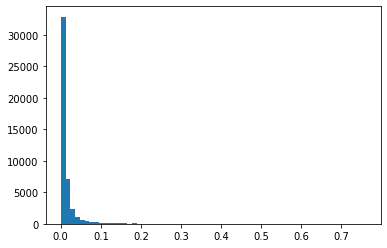

In [ ]:
#excluding zeros, this is the distribution for tf-idf
plt.hist(other,64)
plt.show()

In [ ]:
# until 0.25, we will make 64 bins
# bin for 0 is 0
# 64 bins in 0 to 0.25
# 36 bins in 0.25 to maxvalue (0.65)

bins = list(np.linspace(0,0.25,64,endpoint=False)) + list(np.linspace(0.25,max_val,36))
print(len(bins),bins)

100 [0.0, 0.00390625, 0.0078125, 0.01171875, 0.015625, 0.01953125, 0.0234375, 0.02734375, 0.03125, 0.03515625, 0.0390625, 0.04296875, 0.046875, 0.05078125, 0.0546875, 0.05859375, 0.0625, 0.06640625, 0.0703125, 0.07421875, 0.078125, 0.08203125, 0.0859375, 0.08984375, 0.09375, 0.09765625, 0.1015625, 0.10546875, 0.109375, 0.11328125, 0.1171875, 0.12109375, 0.125, 0.12890625, 0.1328125, 0.13671875, 0.140625, 0.14453125, 0.1484375, 0.15234375, 0.15625, 0.16015625, 0.1640625, 0.16796875, 0.171875, 0.17578125, 0.1796875, 0.18359375, 0.1875, 0.19140625, 0.1953125, 0.19921875, 0.203125, 0.20703125, 0.2109375, 0.21484375, 0.21875, 0.22265625, 0.2265625, 0.23046875, 0.234375, 0.23828125, 0.2421875, 0.24609375, 0.25, 0.26455934289095334, 0.2791186857819067, 0.2936780286728601, 0.3082373715638134, 0.32279671445476676, 0.3373560573457201, 0.35191540023667345, 0.3664747431276268, 0.38103408601858013, 0.39559342890953353, 0.4101527718004868, 0.4247121146914402, 0.43927145758239355, 0.4538308004733469,

In [ ]:
# assigning into bins

df_bins = np.digitize(df,bins,right=True)

In [ ]:
print(df_bins.shape)

(65, 10744)


In [ ]:
# the tfidf(bins) dataframe
x = pd.DataFrame(df_bins)
x = x.values

# the vocab for identifying word
vocab  = tfidf.vocabulary_

# for generating the corresponding word tfidf vector
def get_tfidf_vec(word,corp_id,data=x,vocab = vocab, rev_ids = rev_ids):
    col = vocab[word]
    row = rev_ids[corp_id]
    cat = x[row][col]
    vec = list(np.zeros(100).astype(int))
    vec[cat] = 1
    return vec

## **Creating Model using Tensorflow Backend**

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed, Attention
from keras.layers.wrappers import Bidirectional
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping

In [ ]:
import sys
# insert at 1, 0 is the script path (or '' in REPL)
sys.path.insert(1, '/content/drive/My Drive/NLP (ML)')

import attention

In [ ]:
tf.__version__

'2.3.0'

Importing Supplementary Data (Amazon Review Dataset)


In [ ]:
data=pd.read_csv("/content/drive/My Drive/NLP (ML)/Reviews.csv",nrows=100000)

In [ ]:
data.drop_duplicates(subset=['Text'],inplace=True)  #dropping duplicates
data.dropna(axis=0,inplace=True)   #dropping na

In [ ]:
contraction_mapping = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",

                           "didn't": "did not", "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",

                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",

                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",

                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",

                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",

                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",

                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",

                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",

                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",

                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",

                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",

                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",

                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",

                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",

                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",

                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",

                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",

                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",

                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",

                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",

                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",

                           "you're": "you are", "you've": "you have"}

In [ ]:
import nltk

In [ ]:
nltk.download('stopwords')
from nltk.corpus import stopwords


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
from bs4 import BeautifulSoup
import re

In [ ]:
data['Text'][:10]

0    I have bought several of the Vitality canned d...
1    Product arrived labeled as Jumbo Salted Peanut...
2    This is a confection that has been around a fe...
3    If you are looking for the secret ingredient i...
4    Great taffy at a great price.  There was a wid...
5    I got a wild hair for taffy and ordered this f...
6    This saltwater taffy had great flavors and was...
7    This taffy is so good.  It is very soft and ch...
8    Right now I'm mostly just sprouting this so my...
9    This is a very healthy dog food. Good for thei...
Name: Text, dtype: object

In [ ]:
stop_words = set(stopwords.words('english')) 
def text_cleaner(text):
    newString = text.lower()
    newString = BeautifulSoup(newString, "lxml").text
    newString = re.sub(r'\([^)]*\)', '', newString)
    newString = re.sub('"','', newString)
    newString = ' '.join([contraction_mapping[t] if t in contraction_mapping else t for t in newString.split(" ")])    
    newString = re.sub(r"'s\b","",newString)
    newString = re.sub("[^a-zA-Z]", " ", newString) 
    tokens = [w for w in newString.split() if not w in stop_words]
    long_words=[]
    for i in tokens:
        if len(i)>=3:                  #removing short word
            long_words.append(i)   
    return (" ".join(long_words)).strip()

cleaned_text = []
for t in data['Text']:
    cleaned_text.append(text_cleaner(t))

In [ ]:
data['Summary'][:10]

0                            Good Quality Dog Food
1                                Not as Advertised
2                            "Delight" says it all
3                                   Cough Medicine
4                                      Great taffy
5                                       Nice Taffy
6    Great!  Just as good as the expensive brands!
7                           Wonderful, tasty taffy
8                                       Yay Barley
9                                 Healthy Dog Food
Name: Summary, dtype: object

In [ ]:
def summary_cleaner(text):
    newString = re.sub('"','', text)
    newString = ' '.join([contraction_mapping[t] if t in contraction_mapping else t for t in newString.split(" ")])    
    newString = re.sub(r"'s\b","",newString)
    newString = re.sub("[^a-zA-Z]", " ", newString)
    newString = newString.lower()
    tokens=newString.split()
    newString=''
    for i in tokens:
        if len(i)>1:                                 
            newString=newString+i+' '  
    return newString

#Call the above function
cleaned_summary = []
for t in data['Summary']:
    cleaned_summary.append(summary_cleaner(t))

data['cleaned_text']=cleaned_text
data['cleaned_summary']=cleaned_summary
data['cleaned_summary'].replace('', np.nan, inplace=True)
data.dropna(axis=0,inplace=True)

In [ ]:
data['cleaned_summary'] = data['cleaned_summary'].apply(lambda x : '_START_ '+ x + ' _END_')
for i in range(5):
    print("Review:",data['cleaned_text'][i])
    print("Summary:",data['cleaned_summary'][i])
    print("\n")

Review: bought several vitality canned dog food products found good quality product looks like stew processed meat smells better labrador finicky appreciates product better
Summary: _START_ good quality dog food  _END_


Review: product arrived labeled jumbo salted peanuts peanuts actually small sized unsalted sure error vendor intended represent product jumbo
Summary: _START_ not as advertised  _END_


Review: confection around centuries light pillowy citrus gelatin nuts case filberts cut tiny squares liberally coated powdered sugar tiny mouthful heaven chewy flavorful highly recommend yummy treat familiar story lewis lion witch wardrobe treat seduces edmund selling brother sisters witch
Summary: _START_ delight says it all  _END_


Review: looking secret ingredient robitussin believe found got addition root beer extract ordered made cherry soda flavor medicinal
Summary: _START_ cough medicine  _END_


Review: great taffy great price wide assortment yummy taffy delivery quick taffy lo

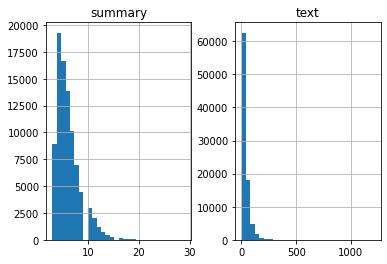

In [ ]:
import matplotlib.pyplot as plt
text_word_count = []
summary_word_count = []

# populate the lists with sentence lengths
for i in data['cleaned_text']:
      text_word_count.append(len(i.split()))

for i in data['cleaned_summary']:
      summary_word_count.append(len(i.split()))

length_df = pd.DataFrame({'text':text_word_count, 'summary':summary_word_count})
length_df.hist(bins = 30)
plt.show()

In [ ]:
max_len_text=80 
max_len_summary=10

In [ ]:
from sklearn.model_selection import train_test_split
x_tr,x_val,y_tr,y_val=train_test_split(data['cleaned_text'],data['cleaned_summary'],test_size=0.1,random_state=0,shuffle=True)

In [ ]:
print(x_tr)

3256     item awesome chocolate flavor would recommend ...
48476    work bar cup tea delicious held lunch later da...
78065    product evil combines dark chocolate macadamia...
29079    nearby fresh easy grocery store small section ...
15364    agree review beware plant pictured anything li...
                               ...                        
22008    bought item dog play smart get food initially ...
49677    love usually eat one day alot alcohol sugar ha...
45709    really high hopes ginger lemon drink got diges...
46981    love cravings place ooey gooey chocolatey chew...
76058    priced well good however wanted mini pecan pie...
Name: cleaned_text, Length: 79516, dtype: object


In [ ]:
#prepare a tokenizer for reviews on training data
x_tokenizer = Tokenizer()
x_tokenizer.fit_on_texts(list(x_tr))

#convert text sequences into integer sequences
x_tr    =   x_tokenizer.texts_to_sequences(x_tr) 
x_val   =   x_tokenizer.texts_to_sequences(x_val)

#padding zero upto maximum length
x_tr    =   pad_sequences(x_tr,  maxlen=max_len_text, padding='post') 
x_val   =   pad_sequences(x_val, maxlen=max_len_text, padding='post')

x_voc_size   =  len(x_tokenizer.word_index) +1

In [ ]:
#preparing a tokenizer for summary on training data 
y_tokenizer = Tokenizer()
y_tokenizer.fit_on_texts(list(y_tr))

#convert summary sequences into integer sequences
y_tr    =   y_tokenizer.texts_to_sequences(y_tr) 
y_val   =   y_tokenizer.texts_to_sequences(y_val) 

#padding zero upto maximum length
y_tr    =   pad_sequences(y_tr, maxlen=max_len_summary, padding='post')
y_val   =   pad_sequences(y_val, maxlen=max_len_summary, padding='post')

y_voc_size  =   len(y_tokenizer.word_index) +1

In [ ]:
x_val[0]

array([ 101,  821, 7479, 3722,  209, 3722,  821,   63, 5388,   47,   61,
       1537,   43,   55,  601,  767,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0], dtype=int32)

In [ ]:
from keras import backend as K 
K.clear_session() 
latent_dim = 500

# Encoder 
encoder_inputs = Input(shape=(max_len_text,)) 
enc_emb = Embedding(x_voc_size, latent_dim,trainable=True)(encoder_inputs) 

#LSTM 1 
encoder_lstm1 = Bidirectional(LSTM(latent_dim,return_sequences=True,return_state=True),input_shape())
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb) 

#LSTM 2 
encoder_lstm2 = Bidirectional(LSTM(latent_dim,return_sequences=True,return_state=True),input_shape()) 
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1) 

#LSTM 3 
encoder_lstm3=Bidirectional(LSTM(latent_dim, return_state=True, return_sequences=True))
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2) 

# Set up the decoder. 
decoder_inputs = Input(shape=(None,)) 
dec_emb_layer = Embedding(y_voc_size, latent_dim,trainable=True) 
dec_emb = dec_emb_layer(decoder_inputs) 

#LSTM using encoder_states as initial state
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True) 
decoder_outputs,decoder_fwd_state, decoder_back_state = decoder_lstm(dec_emb,initial_state=[state_h, state_c]) 

#Attention Layer
attn_layer = attention.AttentionLayer(name='attention_layer')
attn_out, attn_states = attn_layer([encoder_outputs, decoder_outputs]) 

# Concat attention output and decoder LSTM output 
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

#Dense layer
decoder_dense = TimeDistributed(Dense(y_voc_size, activation='softmax')) 
decoder_outputs = decoder_dense(decoder_concat_input) 

# Define the model
model = Model([encoder_inputs, decoder_inputs], decoder_outputs) 
model.summary()

AttributeError: ignored

In [ ]:
from keras import backend as K 
K.clear_session() 
latent_dim = 500

encoder_inputs = Input(shape=(max_len_text,)) 
enc_emb = Embedding(x_voc_size, latent_dim,trainable=True)(encoder_inputs) 

#LSTM 1 
encoder_lstm1 = Bidirectional(LSTM(latent_dim,return_sequences=True,return_state=True))
encoder_output1 = encoder_lstm1(enc_emb) 

testmodel = Model(encoder_inputs,encoder_output1) 
testmodel.summary()

AttributeError: ignored

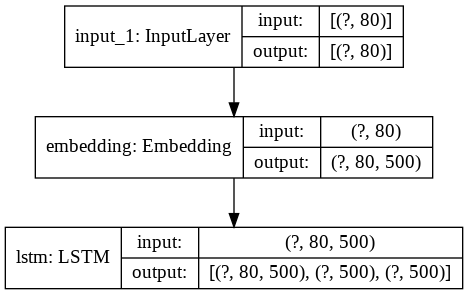

In [ ]:
keras.utils.plot_model(testmodel, "my_first_model_with_shape_info.png", show_shapes=True)

In [ ]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')

In [ ]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1)

In [ ]:
history=model.fit([x_tr,y_tr[:,:-1]], y_tr.reshape(y_tr.shape[0],y_tr.shape[1], 1)[:,1:] ,epochs=50,callbacks=[es],batch_size=512, validation_data=([x_val,y_val[:,:-1]], y_val.reshape(y_val.shape[0],y_val.shape[1], 1)[:,1:]))

Epoch 1/50
156/156 [==============================] - 183s 1s/step - loss: 3.2078 - val_loss: 2.7508
Epoch 2/50
156/156 [==============================] - 183s 1s/step - loss: 2.7253 - val_loss: 2.4930
Epoch 3/50
156/156 [==============================] - 183s 1s/step - loss: 2.4911 - val_loss: 2.3599
Epoch 4/50
156/156 [==============================] - 183s 1s/step - loss: 2.3338 - val_loss: 2.2744
Epoch 5/50
156/156 [==============================] - 183s 1s/step - loss: 2.2129 - val_loss: 2.2307
Epoch 6/50
156/156 [==============================] - 183s 1s/step - loss: 2.1120 - val_loss: 2.1793
Epoch 7/50
156/156 [==============================] - 182s 1s/step - loss: 2.0196 - val_loss: 2.1553
Epoch 8/50
156/156 [==============================] - 182s 1s/step - loss: 1.9316 - val_loss: 2.1489
Epoch 9/50
156/156 [==============================] - 182s 1s/step - loss: 1.8466 - val_loss: 2.1400
Epoch 10/50
156/156 [==============================] - 182s 1s/step - loss: 1.7633 - val_lo

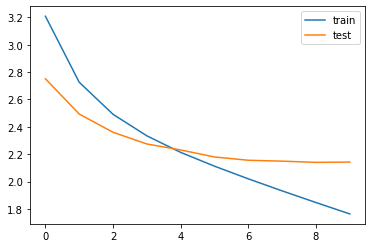

In [ ]:
from matplotlib import pyplot 
pyplot.plot(history.history['loss'], label='train') 
pyplot.plot(history.history['val_loss'], label='test') 
pyplot.legend() 
pyplot.show()

In [ ]:
reverse_target_word_index=y_tokenizer.index_word 
reverse_source_word_index=x_tokenizer.index_word 
target_word_index=y_tokenizer.word_index

In [ ]:
model.save('/content/drive/My Drive/NLP (ML)/trainedmodel')

INFO:tensorflow:Assets written to: /content/drive/My Drive/NLP (ML)/trainedmodel/assets


In [ ]:
# encoder inference
encoder_model = Model(inputs=encoder_inputs,outputs=[encoder_outputs, state_h, state_c])

# decoder inference
# Below tensors will hold the states of the previous time step
decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_hidden_state_input = Input(shape=(max_len_text,latent_dim))

# Get the embeddings of the decoder sequence
dec_emb2= dec_emb_layer(decoder_inputs)

# To predict the next word in the sequence, set the initial states to the states from the previous time step
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

#attention inference
attn_out_inf, attn_states_inf = attn_layer([decoder_hidden_state_input, decoder_outputs2])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# A dense softmax layer to generate prob dist. over the target vocabulary
decoder_outputs2 = decoder_dense(decoder_inf_concat)

# Final decoder model
decoder_model = Model(
[decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
[decoder_outputs2] + [state_h2, state_c2])

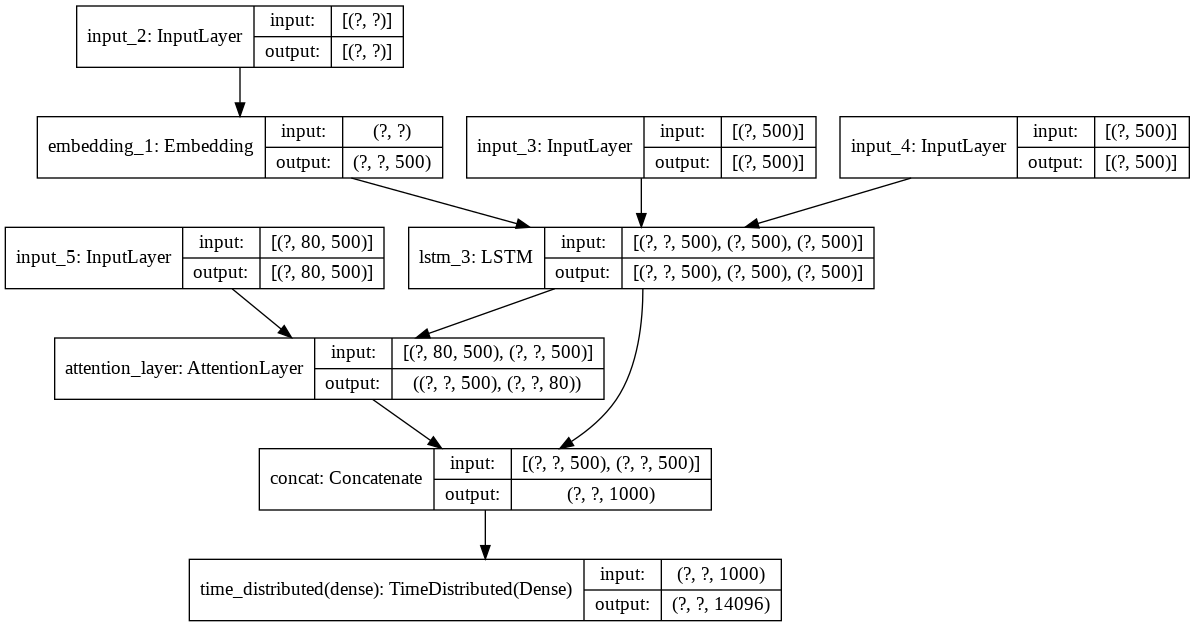

In [ ]:
keras.utils.plot_model(decoder_model, "my_first_model_with_shape_info.png", show_shapes=True)

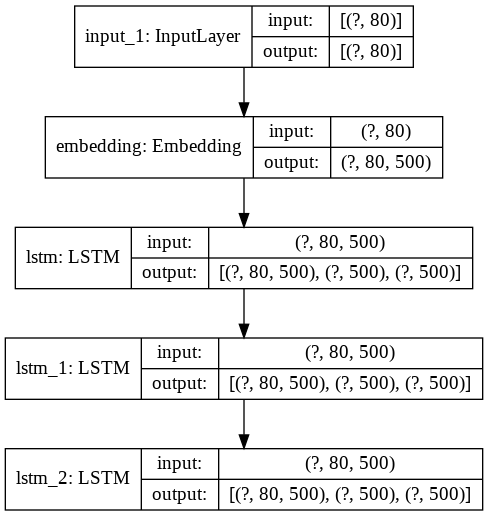

In [ ]:
keras.utils.plot_model(encoder_model, "my_first_model_with_shape_info.png", show_shapes=True)

In [ ]:
def decode_sequence(input_seq):
    # Encode the input as state vectors.
    e_out, e_h, e_c = encoder_model.predict(input_seq)

    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1,1))

    # Chose the 'start' word as the first word of the target sequence
    target_seq[0, 0] = target_word_index['start']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        if(sampled_token_index == 0):
          break
        sampled_token = reverse_target_word_index[sampled_token_index]

        if(sampled_token!='end'):
            decoded_sentence += ' '+sampled_token

            # Exit condition: either hit max length or find stop word.
            if (sampled_token == 'end' or len(decoded_sentence.split()) >= (max_len_summary-1)):
                stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # Update internal states
        e_h, e_c = h, c

    return decoded_sentence

In [ ]:
def seq2summary(input_seq):
    newString=''
    for i in input_seq:
      if((i!=0 and i!=target_word_index['start']) and i!=target_word_index['end']):
        newString=newString+reverse_target_word_index[i]+' '
    return newString

def seq2text(input_seq):
    newString=''
    for i in input_seq:
      if(i!=0):
        newString=newString+reverse_source_word_index[i]+' '
    return newString

In [ ]:
for i in range(10):
    print("Review:",seq2text(x_val[i]))
    print("Original summary:",seq2summary(y_val[i]))
    print("Predicted summary:",decode_sequence(x_val[i].reshape(1,max_len_text)))
    print("\n")

Review: ordered salmon thursday january received january salmon delicious wooden box nice design used store items future 
Original summary: alaska smokehouse smoked salmon 
Predicted summary:  great product


Review: drank cold could pleased coffee high quality arabica always notice coffee arabica robusta sweet without sweet mean cannot compare major bottled coffee brand reason alone keep fridge work offer people without looking like pushing calories along caffeine long time would stock highly sweetened coffee beverages fridge work noticed people stopped consuming happened around time lost interest level sweetness recommend drink prefer lower level sugar old school arabica coffee types 
Original summary: it was perfect little sweet without being too sweet 
Predicted summary:  great tasting coffee


Review: variety granola one ranks top favorites crunch granola coconut main taste sweet overly eat snack craving something fills fast satisfies sugar cravings 
Original summary: great taste 